In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df1 = pd.read_csv('data/online_retail_2009-10.csv')
df2 = pd.read_csv('data/online_retail_2010-11.csv') 
df = pd.concat([df1, df2], ignore_index=True)

In [3]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,01-12-2009 07:45,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,01-12-2009 07:45,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,01-12-2009 07:45,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,01-12-2009 07:45,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,01-12-2009 07:45,1.25,13085.0,United Kingdom


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


In [5]:
1-(824364/1067371 )

0.22766872999172738

22.7% of CustomerID's are missing

In [6]:
df['Customer ID'].isna().sum()

243007

In [7]:
df['Customer ID'] = df['Customer ID'].astype('Int64').astype('string')

In [8]:
df['Customer ID'].isna().sum()

243007

In [9]:
unique_ids = df['Customer ID'].value_counts()
unique_ids.count()

5942

<Axes: title={'center': 'Proportion of Null Customer IDs by Month'}, xlabel='InvoiceDate'>

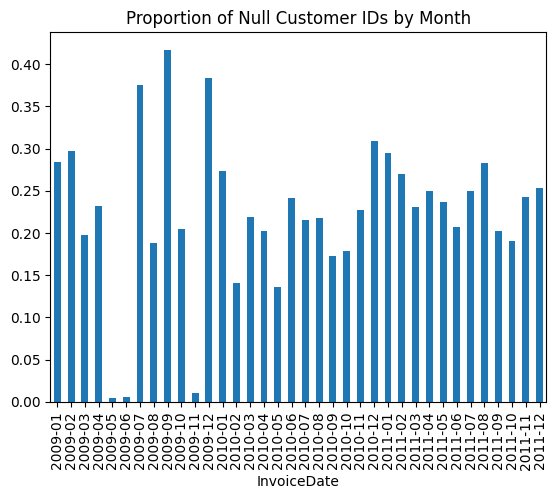

In [10]:
# Convert to datetime if not already
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Create a flag for null customerid
df['is_null_customer'] = df['Customer ID'].isnull()

# Group by month (or day/week) and count nulls
nulls_by_month = df.groupby(df['InvoiceDate'].dt.to_period('M'))['is_null_customer'].mean()

# Plot it
nulls_by_month.plot(kind='bar', title='Proportion of Null Customer IDs by Month')

<Axes: title={'center': 'Proportion of Null Customer IDs by Category'}, xlabel='StockCode'>

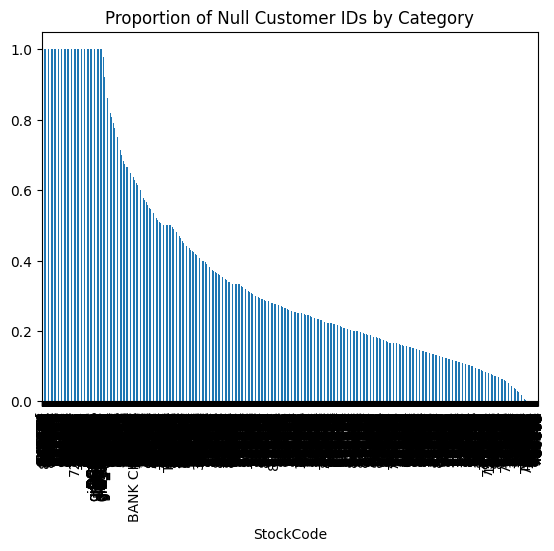

In [11]:
# Group by product category (or description) and calculate null rate
nulls_by_category = df.groupby('StockCode')['is_null_customer'].mean().sort_values(ascending=False)

nulls_by_category.plot(kind='bar', title='Proportion of Null Customer IDs by Category')

In [12]:
invoice_checkouts = df[df['Customer ID'].isnull() & df['Invoice'].notnull()]

In [13]:
invoice_checkouts['Invoice'].nunique()  # How many unique invoices?
invoice_checkouts['InvoiceDate'].value_counts().head()  # Time clustering?

2010-06-12 16:57:00    1350
2010-09-12 14:09:00    1304
2010-07-12 15:28:00    1202
2010-06-12 09:58:00    1194
2010-03-12 11:36:00    1186
Name: InvoiceDate, dtype: int64

In [14]:
# Find duplicated invoices among null customerid rows
dup_invoices = invoice_checkouts['Invoice'].value_counts()
suspicious_invoices = dup_invoices[dup_invoices > 1].index

bulk_or_error = invoice_checkouts[invoice_checkouts['Invoice'].isin(suspicious_invoices)]
print(f"Bulk/system error candidates: {len(bulk_or_error)}")

Bulk/system error candidates: 237020


In [15]:
guest_checkouts = len(invoice_checkouts) - len(bulk_or_error)
print(f"Actual Guest checkouts: {guest_checkouts} rows")

Actual Guest checkouts: 5987 rows


In [16]:
df_clv = df[~df.index.isin(bulk_or_error.index) & df['Customer ID'].notnull()]

In [17]:
summary = pd.DataFrame({
    'Category': ['Valid CLV rows', 'Guest checkouts', 'Bulk/system errors'],
    'Count': [len(df_clv), guest_checkouts, len(bulk_or_error)]
})
print(summary)

             Category   Count
0      Valid CLV rows  824364
1     Guest checkouts    5987
2  Bulk/system errors  237020


In [23]:
# Ensure datetime format
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Clean customerid
df['Customer ID'] = df['Customer ID'].astype('Int64')

# Filter valid rows
df_clv = df[df['Customer ID'].notnull()]

In [33]:
df.to_csv('cleaned_dataset.csv', index=False)

In [34]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,is_null_customer,transaction_value
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-01-12 07:45:00,6.95,13085,United Kingdom,False,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-01-12 07:45:00,6.75,13085,United Kingdom,False,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-01-12 07:45:00,6.75,13085,United Kingdom,False,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-01-12 07:45:00,2.10,13085,United Kingdom,False,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-01-12 07:45:00,1.25,13085,United Kingdom,False,30.0


In [24]:
df['transaction_value'] = df['Quantity'] * df['Price']

In [25]:
clv_df = df_clv.groupby('Customer ID').agg({
    'InvoiceDate': [lambda x: (df_clv['InvoiceDate'].max() - x.max()).days,  # Recency
                     'count'],  # Frequency
    'transaction_value': 'sum'  # Monetary
})

clv_df.columns = ['recency', 'frequency', 'monetary']
clv_df = clv_df.reset_index()

In [26]:
clv_df.head()

,Customer ID,recency,frequency,monetary
0,12346,326,48,-64.68
1,12347,40,253,5633.32
2,12348,76,51,2019.40
3,12349,19,180,4404.54
4,12350,311,17,334.40


In [27]:
clv_df['R'] = pd.qcut(clv_df['recency'], 4, labels=[4, 3, 2, 1])
clv_df['F'] = pd.qcut(clv_df['frequency'].rank(method='first'), 4, labels=[1, 2, 3, 4])
clv_df['M'] = pd.qcut(clv_df['monetary'], 4, labels=[1, 2, 3, 4])

clv_df['RFM_score'] = clv_df['R'].astype(str) + clv_df['F'].astype(str) + clv_df['M'].astype(str)

<Axes: xlabel='monetary', ylabel='Count'>

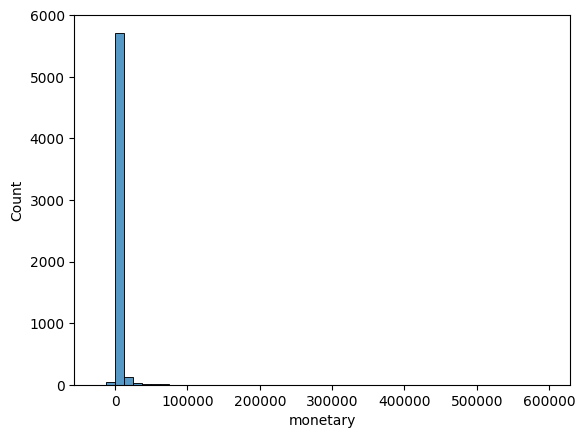

In [28]:
import seaborn as sns
sns.histplot(clv_df['monetary'], bins=50)

In [31]:
clv_df.head()

,Customer ID,recency,frequency,monetary,R,F,M,RFM_score
0,12346,326,48,-64.68,2,2,1,221
1,12347,40,253,5633.32,3,4,4,344
2,12348,76,51,2019.40,3,2,3,323
3,12349,19,180,4404.54,4,4,4,444
4,12350,311,17,334.40,2,1,2,212


In [32]:
clv_df.to_csv('clean_clv_dataset.csv', index=False)